<a href="https://colab.research.google.com/github/AroojArifNU/DLTest/blob/main/Colab_Notebooks/CIFAR_Dataset_RobustBench_Multimodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **multiple_attacks_pytorch_resnet18**

In [ ]:
pip install eagerpy

In [ ]:
pip install foolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
#!/usr/bin/env python3
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa
import numpy as np


if __name__ == "__main__":
    # instantiate a model (could also be a TensorFlow or JAX model)
    model = models.resnet18(pretrained=True).eval()
    preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
    fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

    # get data and test the model
    # wrapping the tensors with ep.astensors is optional, but it allows
    # us to work with EagerPy tensors in the following
    images, labels = ep.astensors(*samples(fmodel, dataset="imagenet", batchsize=16))
    clean_acc = accuracy(fmodel, images, labels)
    print(f"clean accuracy:  {clean_acc * 100:.1f} %")
    print("")

    attacks = [
        fa.FGSM(),
        fa.LinfPGD(),
        fa.LinfBasicIterativeAttack(),
        fa.LinfDeepFoolAttack(),
    ]

    epsilons = [
        0.0,
        0.0005,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.005,
        0.01,
        0.02,
        0.03,
        0.1,
        0.3,
        0.5,
        1.0,
    ]
    print("epsilons")
    print(epsilons)
    print("")

    attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
    for i, attack in enumerate(attacks):
        _, _, success = attack(fmodel, images, labels, epsilons=epsilons)
        assert success.shape == (len(epsilons), len(images))
        success_ = success.numpy()
        assert success_.dtype == np.bool
        attack_success[i] = success_
        print(attack)
        print("  ", 1.0 - success_.mean(axis=-1).round(2))

    # calculate and report the robust accuracy (the accuracy of the model when
    # it is attacked) using the best attack per sample
    robust_accuracy = 1.0 - attack_success.max(axis=0).mean(axis=-1)
    print("")
    print("-" * 79)
    print("")
    print("worst case (best attack per-sample)")
    print("  ", robust_accuracy.round(2))
    print("")

    print("robust accuracy for perturbations with")
    for eps, acc in zip(epsilons, robust_accuracy):
        print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.8MB/s]


clean accuracy:  93.8 %

epsilons
[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0]



<ipython-input-4-4b0b48b78294>:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
<ipython-input-4-4b0b48b78294>:55: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert success_.dtype == np.bool


LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0.94 0.81 0.44 0.31 0.19 0.06 0.   0.   0.   0.   0.   0.   0.   0.  ]
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)
   [0.94 0.81 0.38 0.19 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
LinfBasicIterativeAttack(rel_stepsize=0.2, abs_stepsize=None, steps=10, random_start=False)
   [0.94 0.75 0.31 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
LinfDeepFoolAttack(steps=50, candidates=10, overshoot=0.02, loss=logits)
   [0.94 0.75 0.31 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]

-------------------------------------------------------------------------------

worst case (best attack per-sample)
   [0.94 0.75 0.31 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]

robust accuracy for perturbations with
  Linf norm ≤ 0.0   : 93.8 %
  Linf norm ≤ 0.0005: 75.0 %
  Linf norm ≤ 0.001 : 31.2 %
  Linf no

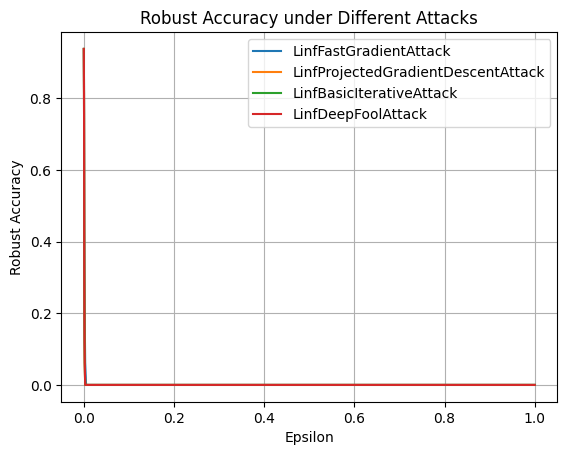

In [ ]:
import matplotlib.pyplot as plt

# ... [rest of your script] ...

# Plotting the robust accuracy graph for each attack
for i, attack in enumerate(attacks):
    # Calculate the robust accuracy: 1 - average success rate for each epsilon
    robust_accuracy = 1.0 - attack_success[i].mean(axis=-1)
    # Use the attack's class name as the label
    attack_name = attack.__class__.__name__
    plt.plot(epsilons, robust_accuracy, label=attack_name)

plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.title('Robust Accuracy under Different Attacks')
plt.legend()
plt.grid(True)
plt.show()


# **CIFAR**

In [ ]:
pip install adversarial-robustness-toolbox

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import load_model

if tf.__version__[0] == "2":
    tf.compat.v1.disable_eager_execution()

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.detector.evasion import BinaryInputDetector

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')



In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
min_

0.0

In [ ]:
max_

1.0

# **RESNET**

In [ ]:
from tensorflow.keras.models import load_model

# Load pre-trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/CIFAR/cifar_resnet.h5')
classifier_model = model
# classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False,
                             preprocessing=(0.5, 1))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
classifier_model.summary()


In [ ]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))

print("Original test data ( 1000 images):")
print("Correctly classified: {}".format(nb_correct_pred))


Original test data ( 1000 images):
Correctly classified: 9241


In [ ]:
import numpy as np

# Assuming x_test is your test data and y_test are the true labels
# And classifier.predict(x_test) is how you obtain predictions

x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
true_labels = np.argmax(y_test, axis=1)

# Identify correctly classified examples
correct_indices = np.where(x_test_pred == true_labels)[0]
correct_examples = x_test[correct_indices]
correct_labels = y_test[correct_indices]

# Count correctly and incorrectly classified examples
nb_correct_pred = len(correct_indices)
nb_incorrect_pred = len(x_test) - nb_correct_pred

print("Original test data (1000 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(nb_incorrect_pred))

# Optionally, save the correctly classified examples and labels
# np.save('correct_examples.npy', correct_examples)
# np.save('correct_labels.npy', correct_labels)


Original test data (1000 images):
Correctly classified: 9241
Incorrectly classified: 759


In [ ]:

!pip install foolbox # Convert data to TensorFlow tensors


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import DeepFool
def perform_attack(attack_class, eps, x_examples, y_true, classifier):
    """
    Perform an attack and return the accuracy.
    """
    attack = attack_class(classifier, eps=eps)
    x_adv = attack.generate(x=x_examples, y=y_true)
    y_pred_adv = np.argmax(classifier.predict(x_adv), axis=1)

    if len(correct_labels.shape) > 1 and correct_labels.shape[1] > 1:
      y_true = np.argmax(correct_labels, axis=1)
    else:
      y_true = correct_labels

    accuracy_adv = accuracy_score(y_true, y_pred_adv)
    return accuracy_adv

# List of attacks to be evaluated
attacks = [FastGradientMethod, BasicIterativeMethod, DeepFool,ProjectedGradientDescent]

# Define the range of eps values
eps_range = [0.03, 0.04, 0.05, 0.1, 0.2, 0.25]

# DataFrame to store the results
results_df = pd.DataFrame(columns=['Attack', 'Epsilon', 'Accuracy'])

# Evaluate each attack at each epsilon value
for attack in attacks:
    for eps in eps_range:
        accuracy_adv = perform_attack(attack, eps, correct_examples, correct_labels, classifier)
        results_df = results_df.append({
            'Attack': attack.__name__,
            'Epsilon': eps,
            'Accuracy': accuracy_adv
        }, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('/content/drive/MyDrive/ColabNotebooks/CIFAR/attack_performance.csv', index=False)

# Print the results
print(results_df)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import pickle
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.estimators.classification import TensorFlowV2Classifier  # Adjust based on your model framework

def perform_and_save_attack(attack_class, eps, x_examples, y_true, classifier, attack_name):
    """
    Perform an attack, return the accuracy, and save the adversarial examples with labels.
    """
    attack = attack_class(classifier, eps=eps)
    x_adv = attack.generate(x=x_examples)
    y_pred_adv = np.argmax(classifier.predict(x_adv), axis=1)

    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_flat = np.argmax(y_true, axis=1)
    else:
        y_true_flat = y_true

    accuracy_adv = accuracy_score(y_true_flat, y_pred_adv)

    # Save the adversarial examples and their true labels
    save_path = '/content/drive/MyDrive/ColabNotebooks/CIFAR/'f'{attack_name}_eps_{eps}.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump({'x_adv': x_adv, 'y_true': y_true}, f)

    return accuracy_adv

# Assuming correct_examples and correct_labels are defined
# Assuming classifier is properly initialized

# List of attacks to be evaluated
attacks = [FastGradientMethod, BasicIterativeMethod, DeepFool, ProjectedGradientDescent]

# Define the range of eps values
eps_range = [0.03, 0.04, 0.05, 0.1, 0.2, 0.25]

# DataFrame to store the results
results = []

# Evaluate each attack at each epsilon value and save the adversarial examples
for attack in attacks:
    for eps in eps_range:
        accuracy_adv = perform_and_save_attack(attack, eps, correct_examples, correct_labels, classifier, attack.__name__)
        results.append({
            'Attack': attack.__name__,
            'Epsilon': eps,
            'Accuracy': accuracy_adv
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the summary of results to a CSV file
results_df.to_csv('/content/drive/MyDrive/ColabNotebooks/CIFAR/attack_performance_summary.csv', index=False)

# Print the results
print(results_df)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the results in a DataFrame named 'results_df'

# Separate data for each attack
attacks = results_df['Attack'].unique()

# Create a color map for each attack
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(10, 6))

# Iterate through attacks and plot accuracy vs. epsilon
for idx, attack in enumerate(attacks):
    attack_df = results_df[results_df['Attack'] == attack]
    plt.plot(attack_df['Epsilon'], attack_df['Accuracy'], marker='o', label=attack, color=colors[idx])

plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon for Different Attacks')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/ColabNotebooks/CIFAR/AdversarialExamples.png', bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/ColabNotebooks/CIFAR/AdversarialExamples.eps', bbox_inches='tight')
plt.show()


# **DenseNet**

In [ ]:
import tensorflow.keras as K
import tensorflow as tf
import numpy as np

def preprocess_data(X, Y):
    X = K.applications.vgg19.preprocess_input(X)
    Y = K.utils.to_categorical(Y, 10)

    return X, Y

if __name__ == '__main__':
    # Divide the data in Train and Test Datasets
    (x_train, y_train),(x_test, y_test) = K.datasets.cifar10.load_data()

    x_train, y_train = preprocess_data(x_train, y_train)
    x_test, y_test = preprocess_data(x_test, y_test)

    model = K.applications.vgg19.VGG19(include_top=False,
                                 weights='imagenet',
                                 input_shape=(224, 224, 3))

    model_1= K.Sequential()
    # model_1.add(K.layers.UpSampling2D((7, 7)))
    model_1.add(model)
    model_1.add(K.layers.AveragePooling2D(pool_size=7))
    model_1.add(K.layers.Flatten())
    model_1.add(K.layers.Dense(10,activation=('softmax')))

    # model.summary()

    checkpoint = K.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/ColabNotebooks/CIFAR/VGG19cifar10.h5',
                                             monitor='val_acc',
                                             mode='max',
                                             verbose=1,
                                             save_best_only=True)

    earlys = K.callbacks.EarlyStopping(monitor='val_acc',
                                       mode='max',
                                       verbose=1,
                                       patience=10)

    model_1.compile(optimizer=K.optimizers.RMSprop(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['acc'])

    model_1.fit(x_train, y_train,
                validation_data=(x_test, y_test),
                batch_size=32,
                epochs=5,
                verbose=1,
                callbacks=[checkpoint, earlys])

    model_1.save('/content/drive/MyDrive/ColabNotebooks/CIFAR/VGG19cifar10.h5')

In [ ]:
# attacker = FastGradientMethod(classifier, eps=0.05)
# x_test_adv = attacker.generate(x_test[:100]) # this takes about two minutes

In [ ]:

# x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
# nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

# print("Adversarial test data (first 1000 images):")
# print("Correctly classified: {}".format(nb_correct_adv_pred))
# print("Incorrectly classified: {}".format(1000-nb_correct_adv_pred))

## Demo - Performance Comparison (CIFAR10)

In [ ]:
pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-ig4pls8n
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-ig4pls8n
  Resolved https://github.com/RobustBench/robustbench.git to commit f6d07682e6ae1a5221b0399a3f3033261a407bbd
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-f4uswiuh/autoattack_dc6288f5a5ee4ec79bc0c67dc68018e0
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-f4uswiuh/autoattack_dc6288f5a5ee4ec79bc0c67dc68018e0
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

In [ ]:
# https://github.com/RobustBench/robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy
# from utils import l2_distance

images, labels = load_cifar10(n_examples=1000)

100%|██████████| 170498071/170498071 [00:02<00:00, 74263738.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
model_list = ['Andriushchenko2020Understanding','Standard', 'Wong2020Fast']
for model_name in model_list:
    model = load_model(model_name, norm='Linf')
    acc = clean_accuracy(model, images, labels)
    print('Model: {}'.format(model_name))
    print('- Standard Acc: {}'.format(acc))

Download started: path=models/cifar10/Linf/Andriushchenko2020Understanding.pt (gdrive_id=1Uyvprd98bIyxfMjLdCZwm-NEJ-6GMVis)
Download finished: path=models/cifar10/Linf/Andriushchenko2020Understanding.pt (gdrive_id=1Uyvprd98bIyxfMjLdCZwm-NEJ-6GMVis)
Model: Andriushchenko2020Understanding
- Standard Acc: 0.808
Download started: path=models/cifar10/Linf/Standard.pt (gdrive_id=1t98aEuzeTL8P7Kpd5DIrCoCL21BNZUhC)
Download finished: path=models/cifar10/Linf/Standard.pt (gdrive_id=1t98aEuzeTL8P7Kpd5DIrCoCL21BNZUhC)
Model: Standard
- Standard Acc: 0.946
Download started: path=models/cifar10/Linf/Wong2020Fast.pt (gdrive_id=1Re--_lf3jCEw9bnQqGkjw3J7v2tSZKrv)
Download finished: path=models/cifar10/Linf/Wong2020Fast.pt (gdrive_id=1Re--_lf3jCEw9bnQqGkjw3J7v2tSZKrv)
Model: Wong2020Fast
- Standard Acc: 0.85


In [ ]:
pip install foolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires pandas<2.1.4,>=1.5.0, but you have pandas 1.3.5 which is incompatible.
bigframes 0.19.2 requires requests>=2.27.1, but you have requests 2.25.1 which is incompatible.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 1.2 MB/s eta 0:00:00


In [ ]:
import datetime
import numpy as np
import warnings

warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.optim as optim

# https://github.com/bethgelab/foolbox
import foolbox as fb
print("foolbox %s"%(fb.__version__))

# https://github.com/IBM/adversarial-robustness-toolbox
import art
import art.attacks.evasion as evasion
from art.estimators.classification import PyTorchClassifier
# from art.classifiers import PyTorchClassifier
print("art %s"%(art.__version__))

import sys
sys.path.insert(0, '..')
# https://github.com/Harry24k/adversarial-attacks-pytorch
import torchattacks
print("torchattacks %s"%(torchattacks.__version__))

foolbox 3.3.3
art 1.17.0
torchattacks 3.5.1


# **FGSM**

In [ ]:
for model_name in model_list:
    print('Model: {}'.format(model_name))
    model = load_model(model_name, norm='Linf')

    print("- Torchattacks")
    atk = torchattacks.FGSM(model, eps=0.25)
    start = datetime.datetime.now()
    adv_images = atk(images, labels)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))

    print("- Foolbox")
    fmodel = fb.PyTorchModel(model, bounds=(0, 1))
    atk = fb.attacks.LinfFastGradientAttack(random_start=False)
    start = datetime.datetime.now()
    _, adv_images, _ = atk(fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=0.25)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))

    # print("- ART")
    # classifier = PyTorchClassifier(model=model, clip_values=(0, 1),
    #                                loss=nn.CrossEntropyLoss(),
    #                                optimizer=optim.Adam(model.parameters(), lr=0.01),
    #                                input_shape=(3, 32, 32), nb_classes=10)
    # atk = evasion.FastGradientMethod(norm=np.inf, batch_size=50,
    #                                  estimator=classifier, eps=8/255)
    # start = datetime.datetime.now()
    # adv_images = torch.tensor(atk.generate(images, labels))
    # end = datetime.datetime.now()
    # acc = clean_accuracy(model, adv_images, labels)
    # print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))

    print()

Model: Andriushchenko2020Understanding
- Torchattacks
- Robust Acc: 0.136 (48687 ms)
- Foolbox
- Robust Acc: 0.136 (1583 ms)

Model: Standard
- Torchattacks
- Robust Acc: 0.096 (158247 ms)
- Foolbox
- Robust Acc: 0.094 (2880 ms)

Model: Wong2020Fast
- Torchattacks
- Robust Acc: 0.118 (18650 ms)
- Foolbox
- Robust Acc: 0.118 (52 ms)



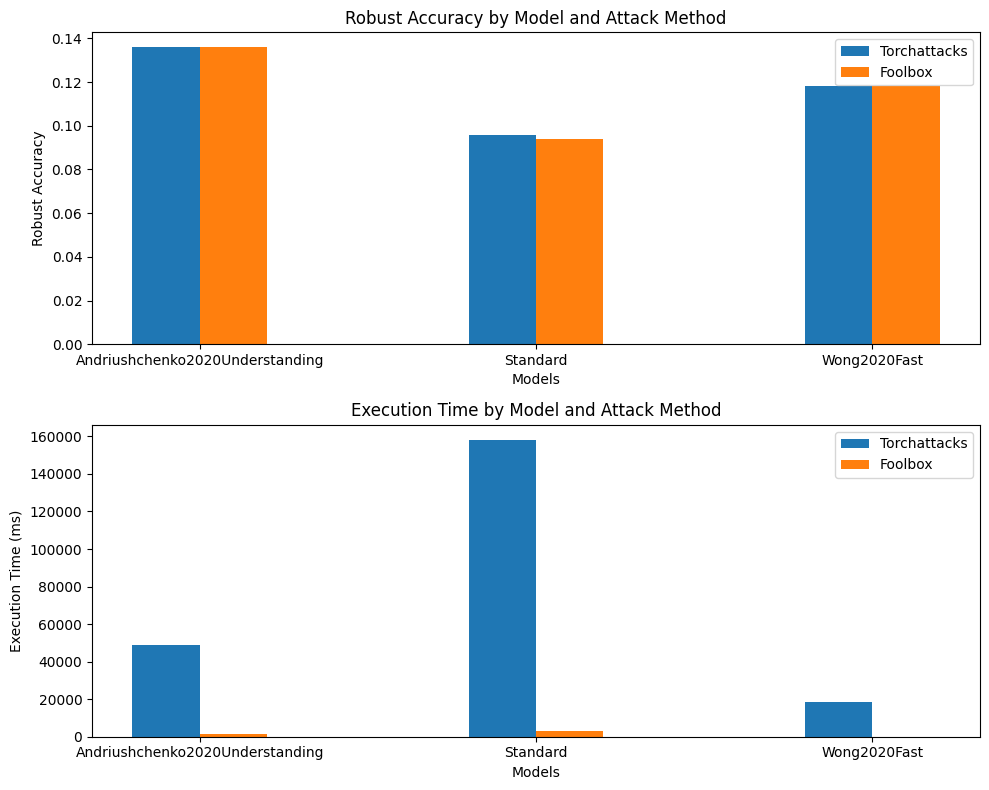

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Updated data based on your values
results = {
    'Andriushchenko2020Understanding': {'Torchattacks': {'accuracy': 0.136, 'time': 48687},
                                        'Foolbox': {'accuracy': 0.136, 'time': 1583}},
    'Standard': {'Torchattacks': {'accuracy': 0.096, 'time': 158247},
                 'Foolbox': {'accuracy': 0.094, 'time': 2880}},
    'Wong2020Fast': {'Torchattacks': {'accuracy': 0.118, 'time': 18650},
                     'Foolbox': {'accuracy': 0.118, 'time': 52}}
}

# Preparing data for plotting
models = list(results.keys())
attacks = ['Torchattacks', 'Foolbox']
accuracy = np.array([[results[model][atk]['accuracy'] for atk in attacks] for model in models])
time = np.array([[results[model][atk]['time'] for atk in attacks] for model in models])

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Two subplots
bar_width = 0.2
index = np.arange(len(models))

for i, attack in enumerate(attacks):
    axs[0].bar(index + i*bar_width, accuracy[:, i], bar_width, label=attack)
    axs[1].bar(index + i*bar_width, time[:, i], bar_width, label=attack)

# Accuracy plot
axs[0].set_xlabel('Models')
axs[0].set_ylabel('Robust Accuracy')
axs[0].set_title('Robust Accuracy by Model and Attack Method')
axs[0].set_xticks(index + bar_width / 2, models)  # Adjusting x-ticks position
axs[0].legend()

# Time plot
axs[1].set_xlabel('Models')
axs[1].set_ylabel('Execution Time (ms)')
axs[1].set_title('Execution Time by Model and Attack Method')
axs[1].set_xticks(index + bar_width / 2, models)  # Adjusting x-ticks position
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import datetime
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

# Other necessary imports...

for model_name in model_list:
    print('Model: {}'.format(model_name))
    model = load_model(model_name, norm='Linf')

    # ART
    print("- ART")
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=nn.CrossEntropyLoss(),
        optimizer=optim.Adam(model.parameters(), lr=0.01),
        input_shape=(3, 32, 32),
        nb_classes=10
    )
    atk = FastGradientMethod(estimator=classifier, eps=0.25, batch_size=64)
    start = datetime.datetime.now()
    adv_images = atk.generate(x=images.cpu().numpy(), y=labels.cpu().numpy())
    end = datetime.datetime.now()
    adv_images_tensor = torch.tensor(adv_images).to('cuda:0' if torch.cuda.is_available() else 'cpu')
    acc = clean_accuracy(model, adv_images_tensor, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))


Model: Andriushchenko2020Understanding
- ART
- Robust Acc: 0.136 (2981 ms)
Model: Standard
- ART
- Robust Acc: 0.094 (2547 ms)
Model: Wong2020Fast
- ART
- Robust Acc: 0.118 (773 ms)


In [ ]:
import datetime
# Other necessary imports

epsilon_values = [0.04, 0.05, 0.15, 0.25]  # List of epsilon values
all_results = {}  # Dictionary to store all results

for eps in epsilon_values:
    print(f"Epsilon: {eps}")
    eps_results = {}  # Dictionary to store results for this epsilon

    for model_name in model_list:
        model_results = {}  # Dictionary to store results for this model
        print('Model: {}'.format(model_name))
        model = load_model(model_name, norm='Linf')

        # Torchattacks
        print("- Torchattacks")
        atk = torchattacks.FGSM(model, eps=eps)
        start = datetime.datetime.now()
        adv_images = atk(images, labels)
        end = datetime.datetime.now()
        acc = clean_accuracy(model, adv_images, labels)
        model_results['Torchattacks'] = {'Robust Acc': acc, 'Time (ms)': int((end-start).total_seconds()*1000)}
        print('- Robust Acc: {} ({} ms)'.format(acc, model_results['Torchattacks']['Time (ms)']))

        # Foolbox
        print("- Foolbox")
        fmodel = fb.PyTorchModel(model, bounds=(0, 1))
        atk = fb.attacks.LinfFastGradientAttack(random_start=False)
        start = datetime.datetime.now()
        _, adv_images, _ = atk(fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=eps)
        end = datetime.datetime.now()
        acc = clean_accuracy(model, adv_images, labels)
        model_results['Foolbox'] = {'Robust Acc': acc, 'Time (ms)': int((end-start).total_seconds()*1000)}
        print('- Robust Acc: {} ({} ms)'.format(acc, model_results['Foolbox']['Time (ms)']))


        # Other attacks (Torchattacks and Foolbox)...

        # ART
        print("- ART")
        classifier = PyTorchClassifier(
            model=model,
            clip_values=(0, 1),
            loss=nn.CrossEntropyLoss(),
            optimizer=optim.Adam(model.parameters(), lr=0.01),
            input_shape=(3, 32, 32),
            nb_classes=10
        )
        atk = FastGradientMethod(estimator=classifier, eps=eps, batch_size=64)
        start = datetime.datetime.now()
        adv_images = atk.generate(x=images.cpu().numpy(), y=labels.cpu().numpy())
        end = datetime.datetime.now()
        adv_images_tensor = torch.tensor(adv_images).to('cuda:0' if torch.cuda.is_available() else 'cpu')
        acc = clean_accuracy(model, adv_images_tensor, labels)
        model_results['ART'] = {'Robust Acc': acc, 'Time (ms)': int((end-start).total_seconds()*1000)}
        print('- Robust Acc: {} ({} ms)'.format(acc, model_results['ART']['Time (ms)']))

        # Add model results to epsilon results
        eps_results[model_name] = model_results
        print()

    # Add epsilon results to all results
    all_results[eps] = eps_results

# Print all results
print("\nAll Results:")
for eps, models in all_results.items():
    print(f"Epsilon: {eps}")
    for model_name, results in models.items():
        print(f'Model: {model_name}')
        for attack, attack_results in results.items():
            print(f'  {attack} - Robust Acc: {attack_results["Robust Acc"]} (Time: {attack_results["Time (ms)"]} ms)')


Epsilon: 0.04
Model: Andriushchenko2020Understanding
- Torchattacks
- Robust Acc: 0.462 (20447 ms)
- Foolbox
- Robust Acc: 0.462 (450 ms)
- ART
- Robust Acc: 0.462 (408 ms)

Model: Standard
- Torchattacks
- Robust Acc: 0.264 (151900 ms)
- Foolbox
- Robust Acc: 0.264 (1773 ms)
- ART
- Robust Acc: 0.264 (2123 ms)

Model: Wong2020Fast
- Torchattacks
- Robust Acc: 0.458 (19505 ms)
- Foolbox
- Robust Acc: 0.458 (13 ms)
- ART
- Robust Acc: 0.458 (411 ms)

Epsilon: 0.05
Model: Andriushchenko2020Understanding
- Torchattacks
- Robust Acc: 0.414 (19842 ms)
- Foolbox
- Robust Acc: 0.414 (15 ms)
- ART
- Robust Acc: 0.414 (421 ms)

Model: Standard
- Torchattacks
- Robust Acc: 0.228 (142765 ms)
- Foolbox
- Robust Acc: 0.232 (38 ms)
- ART
- Robust Acc: 0.232 (2146 ms)

Model: Wong2020Fast
- Torchattacks
- Robust Acc: 0.394 (19497 ms)
- Foolbox
- Robust Acc: 0.394 (13 ms)
- ART
- Robust Acc: 0.394 (415 ms)

Epsilon: 0.15
Model: Andriushchenko2020Understanding
- Torchattacks
- Robust Acc: 0.11 (19313 m

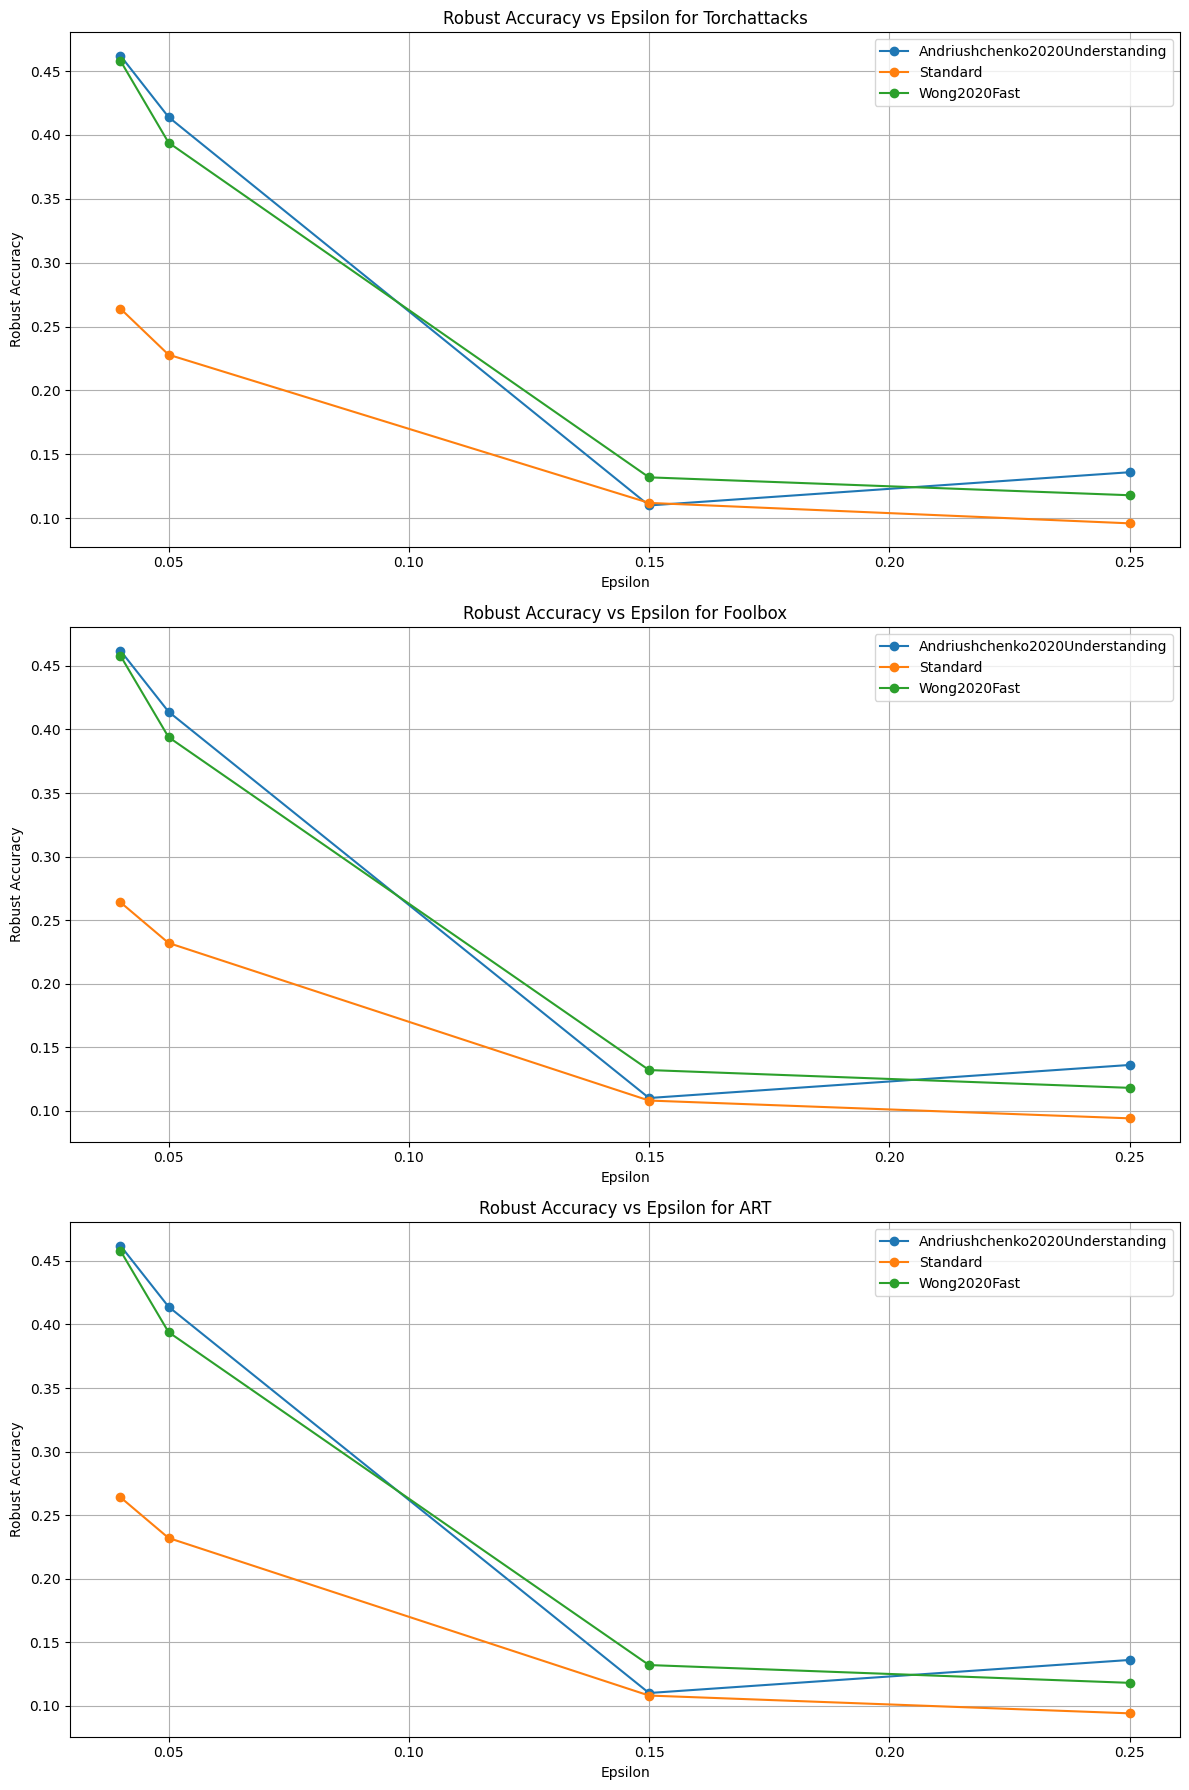

In [ ]:
import matplotlib.pyplot as plt

# Define the attack methods
attack_methods = ['Torchattacks', 'Foolbox', 'ART']

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

for i, attack_method in enumerate(attack_methods):
    for model_name in model_list:
        accuracies = [all_results[eps][model_name].get(attack_method, {}).get('Robust Acc', 0) for eps in epsilon_values]
        axs[i].plot(epsilon_values, accuracies, marker='o', label=model_name)

    axs[i].set_xlabel('Epsilon')
    axs[i].set_ylabel('Robust Accuracy')
    axs[i].set_title(f'Robust Accuracy vs Epsilon for {attack_method}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


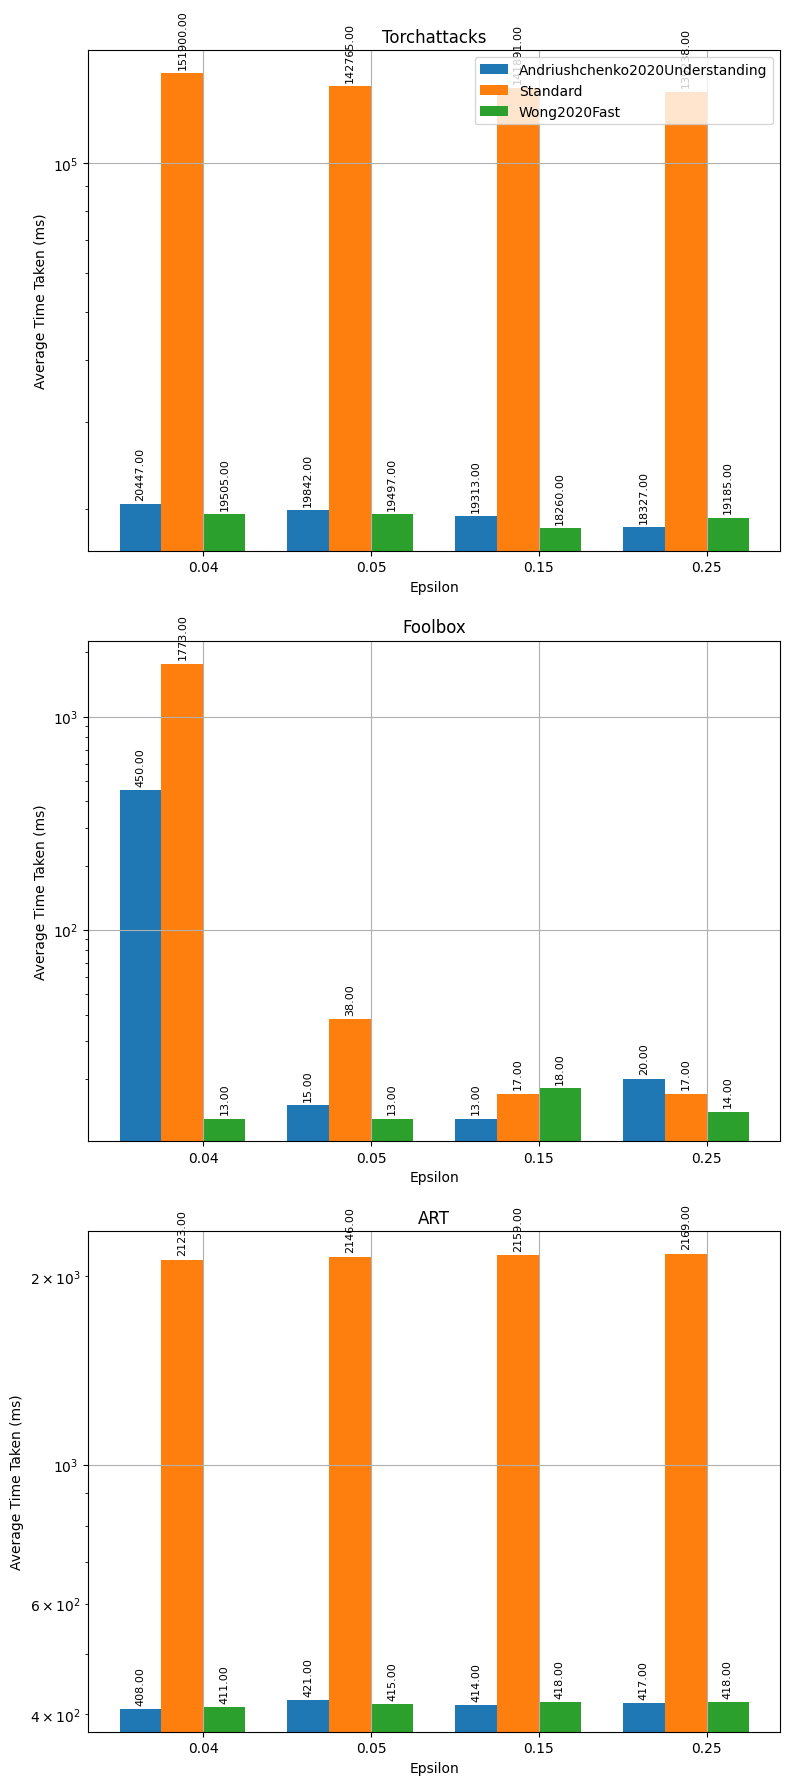

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Bar Chart for Time
bar_width = 0.15
attack_methods = ['Torchattacks', 'Foolbox', 'ART']
num_models = len(model_list)
total_bar_width = num_models * bar_width

# Create a figure with three subplots in a vertical column
fig, axs = plt.subplots(3, 1, figsize=(8, 18))  # Adjust figsize as needed

for i, attack in enumerate(attack_methods):
    index = np.arange(len(epsilon_values)) * (total_bar_width + bar_width)  # X-coordinates of bars
    for j, model_name in enumerate(model_list):
        times = [all_results[eps][model_name].get(attack, {}).get('Time (ms)', 0) for eps in epsilon_values]
        bar_positions = index + j * bar_width
        bars = axs[i].bar(bar_positions, times, bar_width, label=model_name if i == 0 else "")

        # Adding annotations to bars
        for bar in bars:
            height = bar.get_height()
            axs[i].annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', rotation=90, fontsize=8)

    axs[i].set_xlabel('Epsilon')
    axs[i].set_ylabel('Average Time Taken (ms)')
    axs[i].set_title(f'{attack}')
    axs[i].set_xticks(index + total_bar_width / 2)
    axs[i].set_xticklabels(epsilon_values)
    axs[i].set_yscale('log')  # Set logarithmic scale for y-axis
    axs[i].grid(True)
    if i == 0:
        axs[i].legend()

plt.tight_layout()
plt.show()


# **MULTI MODLES ON  Linf**

In [ ]:

# https://github.com/RobustBench/robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy
# from utils import l2_distance

images, labels = load_cifar10(n_examples=500)

In [ ]:
model_list = ['Andriushchenko2020Understanding','Carmon2019Unlabeled', 'Sehwag2020Hydra','Wang2020Improving','Hendrycks2019Using']
for model_name in model_list:
    model = load_model(model_name, norm='Linf')
    acc = clean_accuracy(model, images, labels)
    print('Model: {}'.format(model_name))
    print('- Standard Acc: {}'.format(acc))

Model: Andriushchenko2020Understanding
- Standard Acc: 0.808
Model: Carmon2019Unlabeled
- Standard Acc: 0.902
Model: Sehwag2020Hydra
- Standard Acc: 0.906
Model: Wang2020Improving
- Standard Acc: 0.884
Model: Hendrycks2019Using
- Standard Acc: 0.894


# **Multi models on multi attacls**.
  https://github.com/RobustBench/robustbench/tree/master

In [ ]:
import datetime
import foolbox as fb

# Other necessary imports...

epsilon_values = [0.01,0.02,0.03,0.04, 0.05, 0.15, 0.25]  # List of epsilon values
all_results = {}  # Dictionary to store all results

for eps in epsilon_values:
    print(f"Epsilon: {eps}")
    eps_results = {}  # Dictionary to store results for this epsilon

    for model_name in model_list:
        model_results = {}  # Dictionary to store results for this model
        print('Model: {}'.format(model_name))
        model = load_model(model_name, norm='Linf')
        fmodel = fb.PyTorchModel(model, bounds=(0, 1))

        # List of Foolbox attacks
        attacks = [
            ('FGSM', fb.attacks.FGSM(random_start=False)),
            ('PGD', fb.attacks.LinfPGD(random_start=False)),
            ('DeepFool', fb.attacks.LinfDeepFoolAttack()),
            ('BIM', fb.attacks.LinfBasicIterativeAttack())
        ]

        for attack_name, attack in attacks:
            print(f"- {attack_name}")
            start = datetime.datetime.now()
            _, adv_images, _ = attack(fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=eps)
            end = datetime.datetime.now()
            acc = clean_accuracy(model, adv_images, labels)
            model_results[attack_name] = {'Robust Acc': acc, 'Time (ms)': int((end - start).total_seconds() * 1000)}
            print(f'- Robust Acc: {acc} (Time: {model_results[attack_name]["Time (ms)"]} ms)')

        # Add model results to epsilon results
        eps_results[model_name] = model_results
        print()

    # Add epsilon results to all results
    all_results[eps] = eps_results

# Print all results
print("\nAll Results:")
for eps, models in all_results.items():
    print(f"Epsilon: {eps}")
    for model_name, results in models.items():
        print(f'Model: {model_name}')
        for attack, attack_results in results.items():
            print(f'  {attack} - Robust Acc: {attack_results["Robust Acc"]} (Time: {attack_results["Time (ms)"]} ms)')


Epsilon: 0.01
Model: Andriushchenko2020Understanding
- FGSM
- Robust Acc: 0.74 (Time: 16 ms)
- PGD
- Robust Acc: 0.736 (Time: 13334 ms)
- DeepFool
- Robust Acc: 0.72 (Time: 16982 ms)
- BIM
- Robust Acc: 0.736 (Time: 2807 ms)

Model: Carmon2019Unlabeled
- FGSM
- Robust Acc: 0.844 (Time: 2965 ms)
- PGD
- Robust Acc: 0.838 (Time: 112636 ms)
- DeepFool
- Robust Acc: 0.834 (Time: 109733 ms)
- BIM
- Robust Acc: 0.838 (Time: 24465 ms)

Model: Sehwag2020Hydra
- FGSM
- Robust Acc: 0.852 (Time: 18 ms)
- PGD
- Robust Acc: 0.848 (Time: 110397 ms)
- DeepFool
- Robust Acc: 0.846 (Time: 133199 ms)
- BIM
- Robust Acc: 0.848 (Time: 23801 ms)

Model: Wang2020Improving
- FGSM
- Robust Acc: 0.83 (Time: 17 ms)
- PGD
- Robust Acc: 0.83 (Time: 112763 ms)
- DeepFool
- Robust Acc: 0.816 (Time: 189376 ms)
- BIM
- Robust Acc: 0.83 (Time: 24344 ms)

Model: Hendrycks2019Using
- FGSM
- Robust Acc: 0.824 (Time: 17 ms)
- PGD
- Robust Acc: 0.822 (Time: 111587 ms)
- DeepFool
- Robust Acc: 0.82 (Time: 161093 ms)
- BIM
-

In [ ]:
# Model list as per your specification
model_list = ['Andriushchenko2020Understanding', 'Carmon2019Unlabeled', 'Sehwag2020Hydra', 'Wang2020Improving', 'Hendrycks2019Using']

# Initialize dictionaries to store robust accuracy and time data
robust_accuracies = {model: {eps: {} for eps in epsilon_values} for model in model_list}
times = {model: {eps: {} for eps in epsilon_values} for model in model_list}

# Extract data from all_results
for eps in epsilon_values:
    for model in model_list:
        for attack, result in all_results[eps][model].items():
            robust_accuracies[model][eps][attack] = result['Robust Acc']
            times[model][eps][attack] = result['Time (ms)']


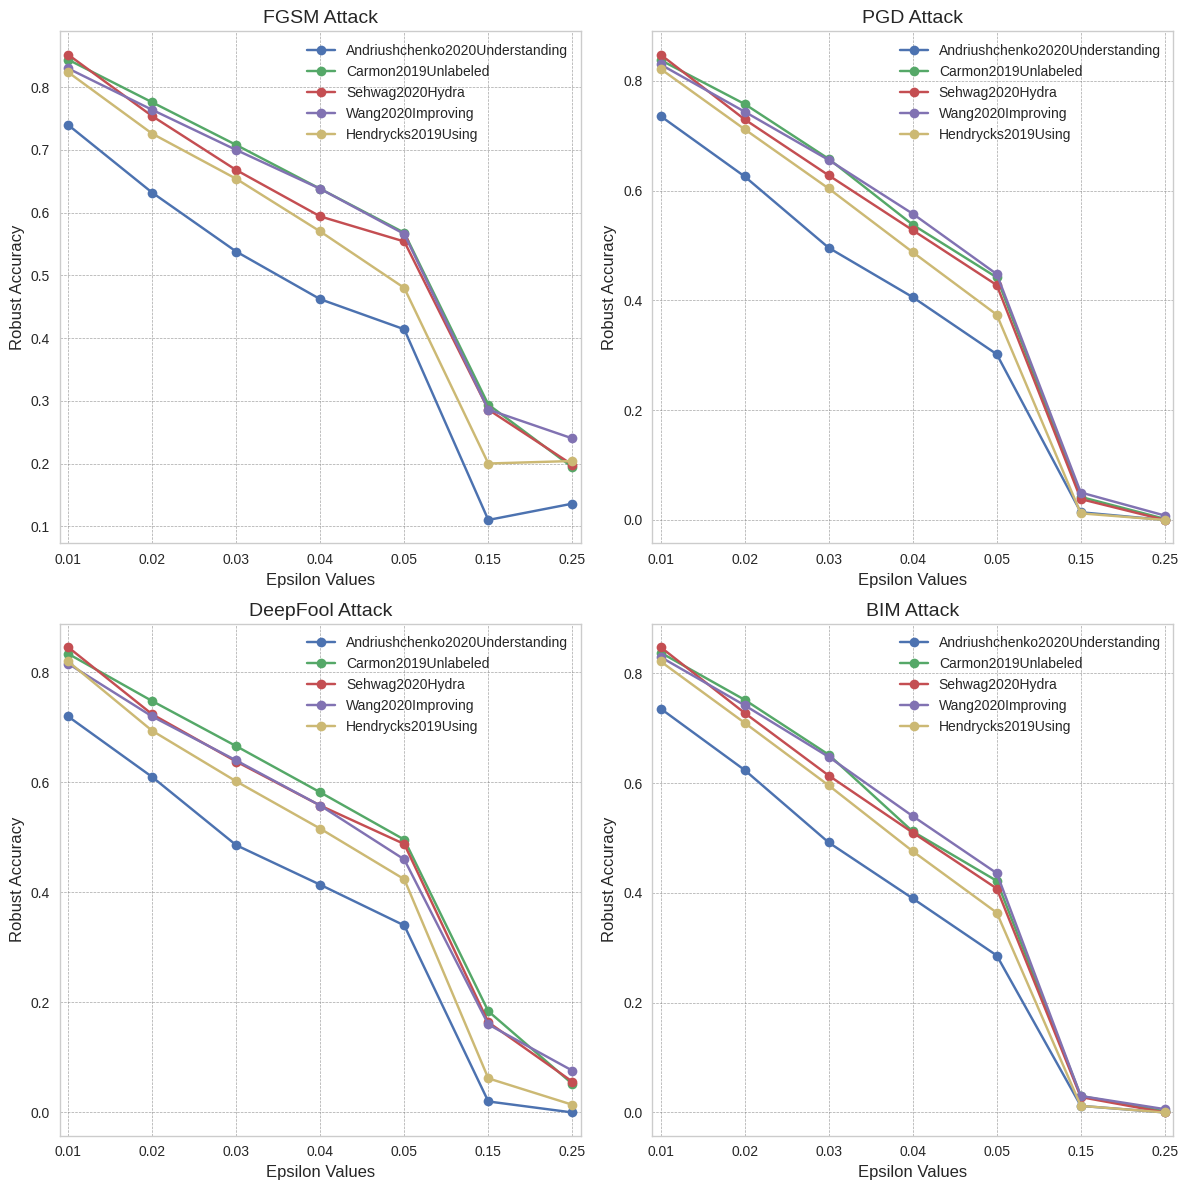

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Applying a style template
plt.style.use('seaborn-whitegrid')

# Define the subplot grid
num_attacks = len(attacks)
cols = 2  # Adjust based on the number of attacks
rows = num_attacks // cols + num_attacks % cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
axes = axes.flatten()  # Flatten in case of a single row

# Evenly spaced points for x-axis
x_points = range(len(epsilon_values))

# Plot data for each attack
for i, attack in enumerate(attacks):
    ax = axes[i]
    for model in model_list:
        accuracies = [robust_accuracies[model][eps][attack] for eps in epsilon_values]
        ax.plot(x_points, accuracies, label=model, marker='o')  # Plotting with even x points

        # # Adding annotations for each point
        # for x, y in zip(x_points, accuracies):
        #     ax.annotate(f'{y*100:.1f}%',  # Convert to percentage and format to 1 decimal place
        #                 (x, y),
        #                 textcoords="offset points",  # Positioning
        #                 xytext=(0, 5),  # Distance from point
        #                 ha='center',  # Horizontal alignment
        #                 fontsize=8)  # Smaller font size

    ax.set_title(f'{attack} Attack', fontsize=14)
    ax.set_xlabel('Epsilon Values', fontsize=12)
    ax.set_ylabel('Robust Accuracy', fontsize=12)

    # Setting x-axis labels to correspond to epsilon values
    ax.set_xticks(x_points)
    ax.set_xticklabels([str(eps) for eps in epsilon_values])

    # Set x-axis limits exactly to the range of x_points
    ax.set_xlim([min(x_points) - 0.1, max(x_points) + 0.1])

    # Explicit grid settings
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


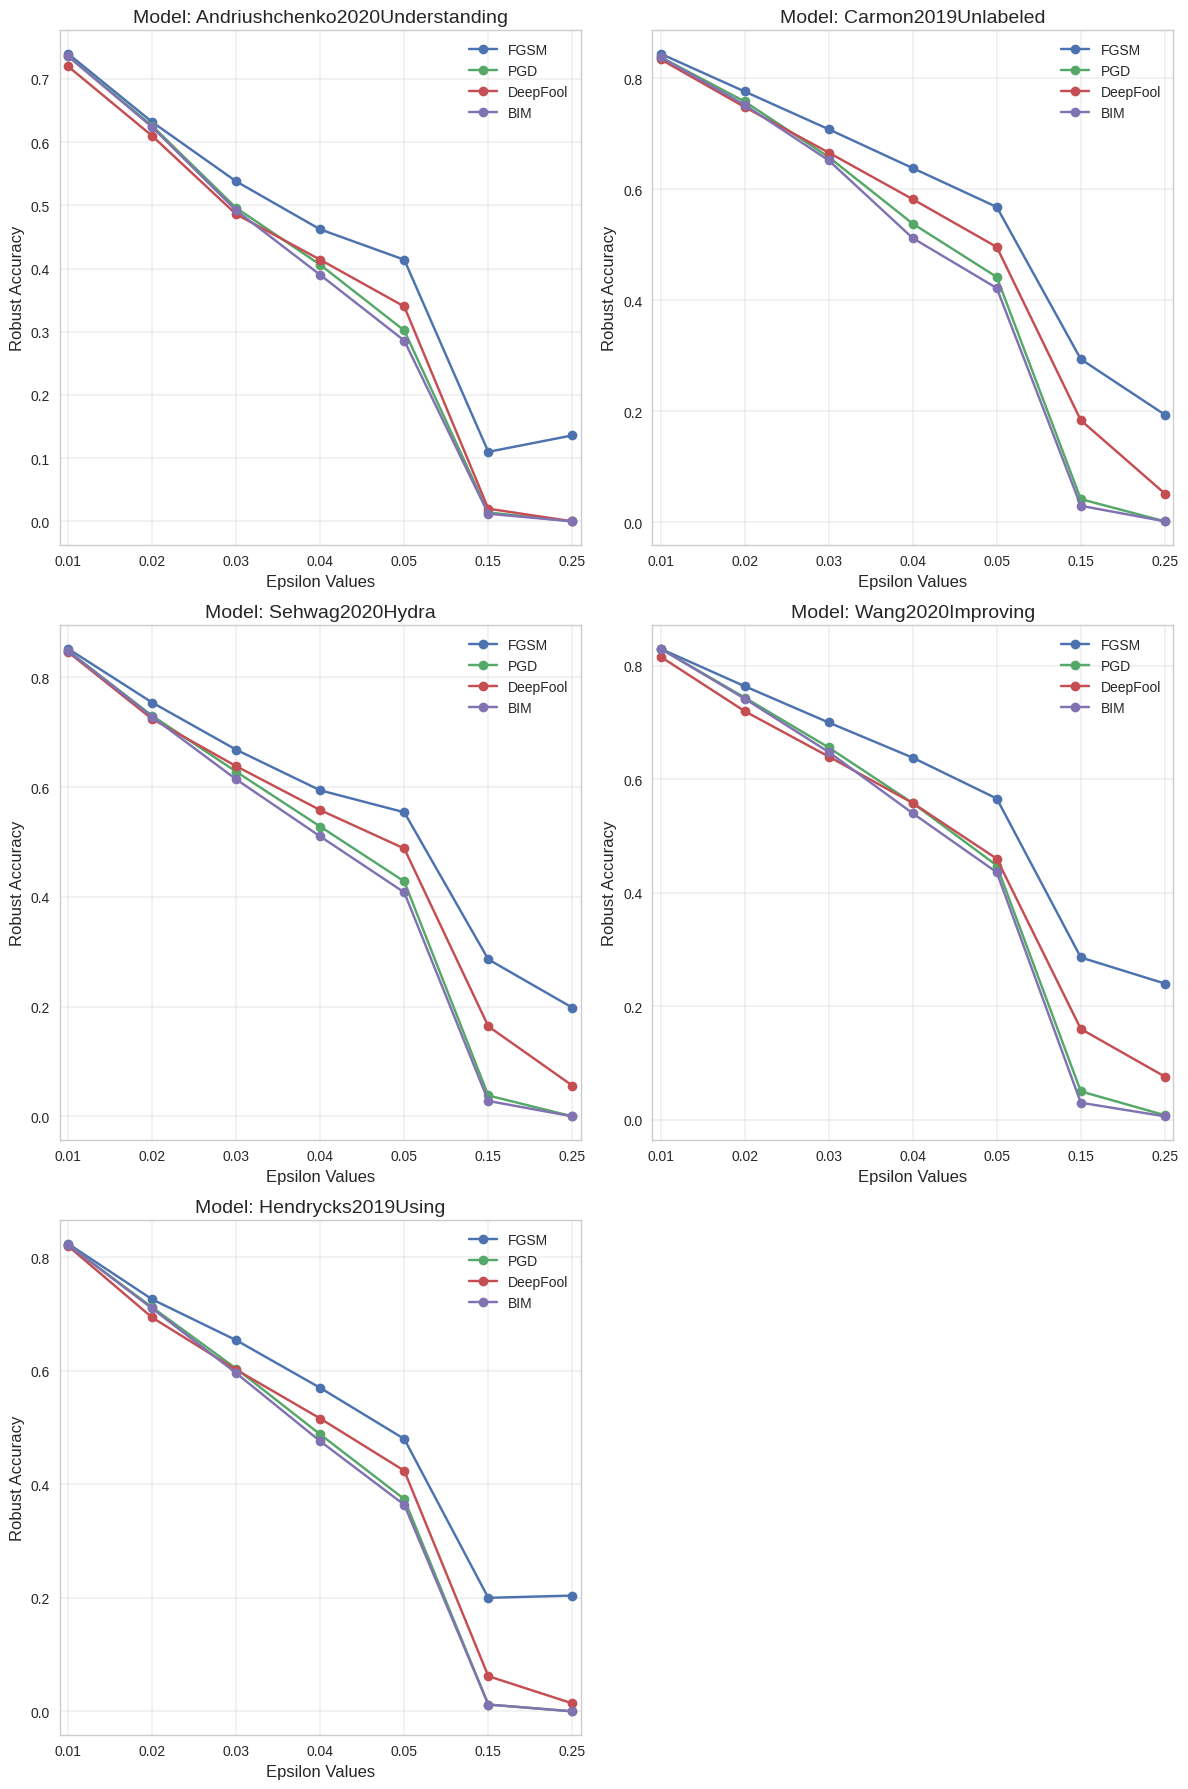

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Applying a style template
plt.style.use('seaborn-whitegrid')

# Define the subplot grid
num_models = len(model_list)
cols = 2  # Adjust based on the number of models
rows = num_models // cols + (num_models % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows), squeeze=False)
axes = axes.flatten()  # Flatten to make indexing easier

# Evenly spaced points for x-axis
x_points = range(len(epsilon_values))

# Function to adjust annotation position
def adjust_annotation_position(ax, x, y, text, fontsize=8):
    # Dynamically adjust position to reduce overlap (can be improved further)
    xytext = (0, 5) if y > 0.5 else (0, -15)
    ax.annotate(text, (x, y), textcoords="offset points", xytext=xytext,
                ha='center', fontsize=fontsize)

# Plot data for each model
for i, model in enumerate(model_list):
    ax = axes[i]
    for attack in attacks:
        accuracies = [robust_accuracies[model][eps][attack] for eps in epsilon_values]
        ax.plot(x_points, accuracies, label=attack, marker='o')

        # # Adding adjusted annotations for each point
        # for x, y in zip(x_points, accuracies):
        #     annotation = f'{y*100:.1f}%'  # Convert to percentage
        #     adjust_annotation_position(ax, x, y, annotation)

    ax.set_title(f'Model: {model}', fontsize=14)
    ax.set_xlabel('Epsilon Values', fontsize=12)
    ax.set_ylabel('Robust Accuracy', fontsize=12)
    ax.set_xticks(x_points)
    ax.set_xticklabels([str(eps) for eps in epsilon_values])

    # Padding for lines
    ax.set_xlim([min(x_points) - 0.1, max(x_points) + 0.1])

    ax.grid(True, linestyle='--', linewidth=0.1, color='black')
    ax.legend()

# Hide last subplot if odd number of models
if num_models % cols != 0:
    axes[-1].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()


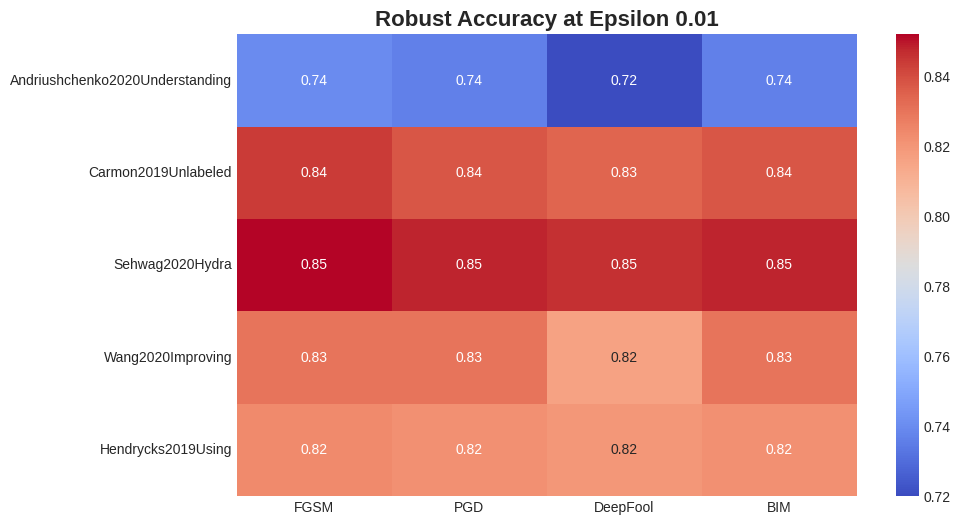

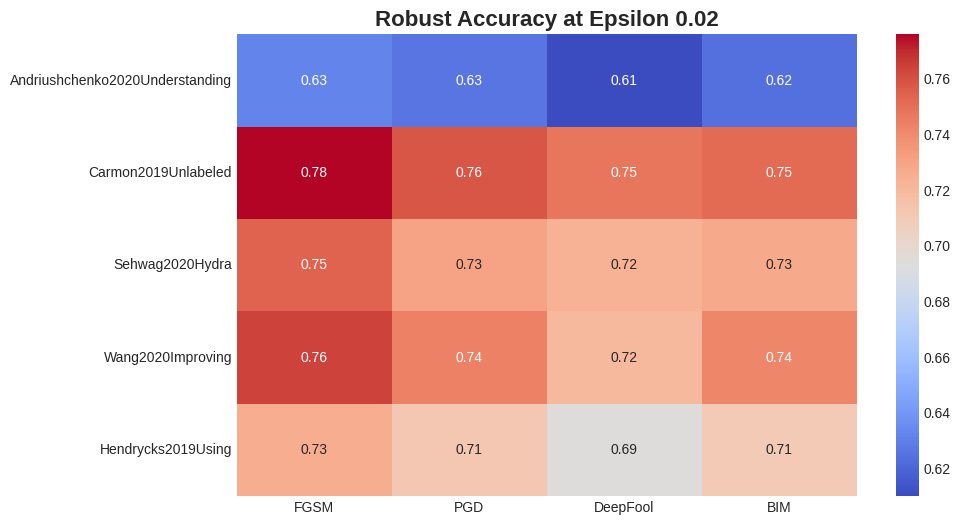

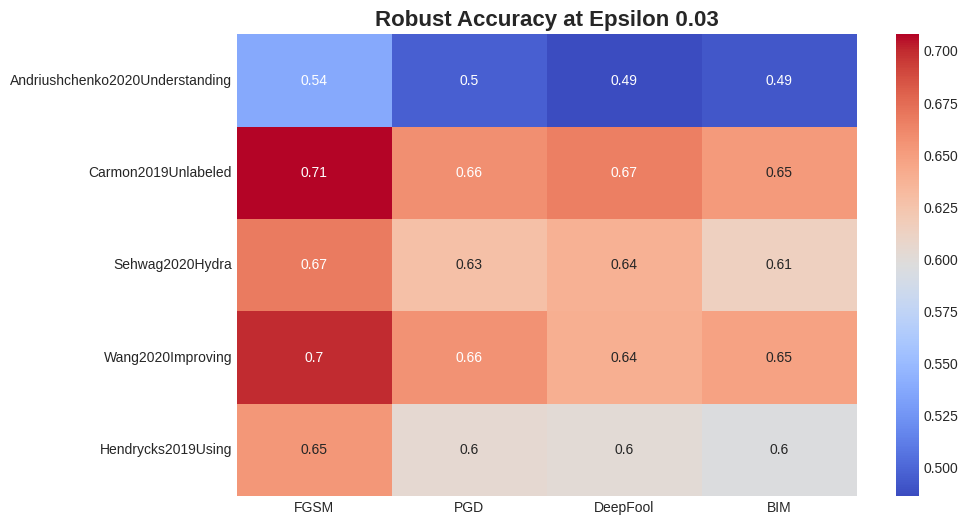

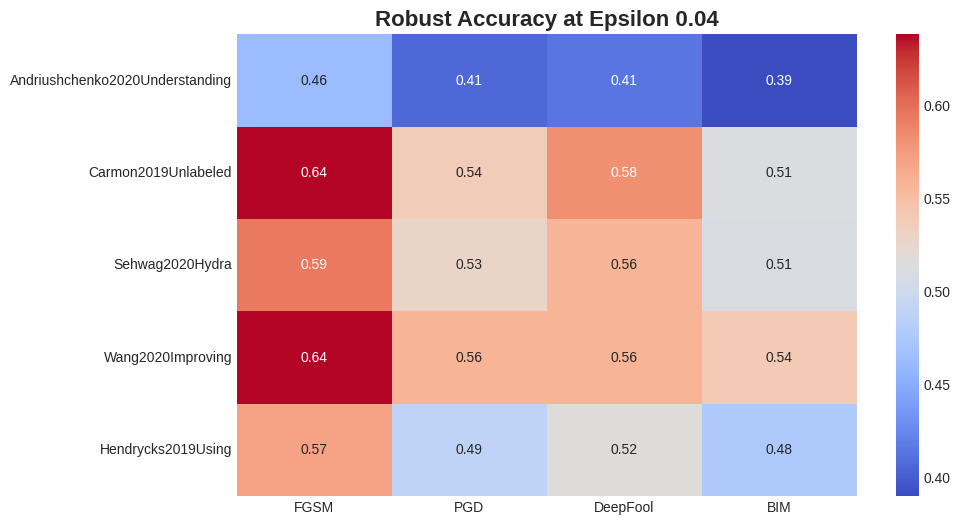

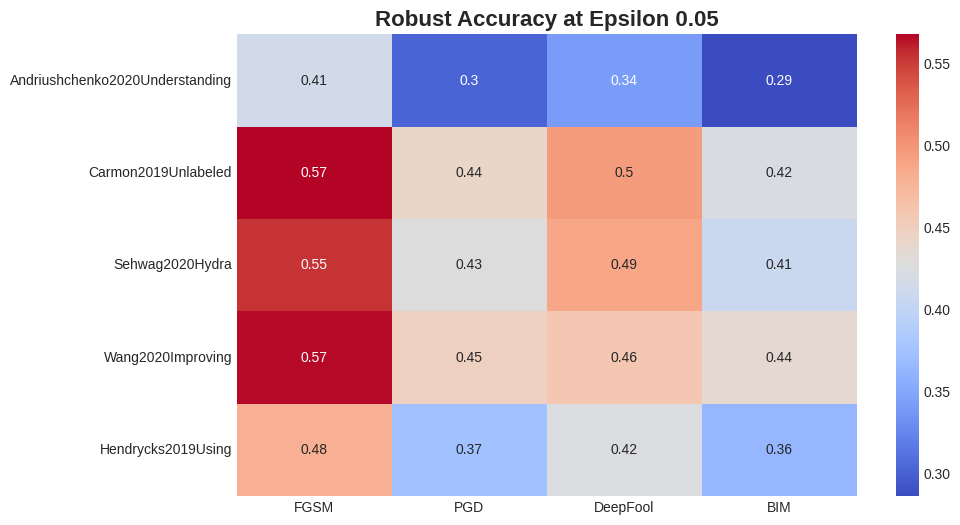

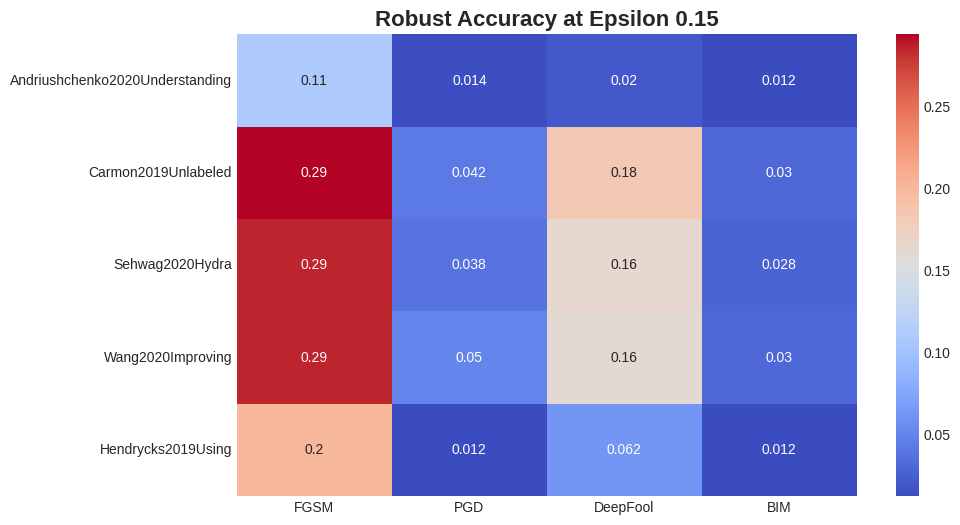

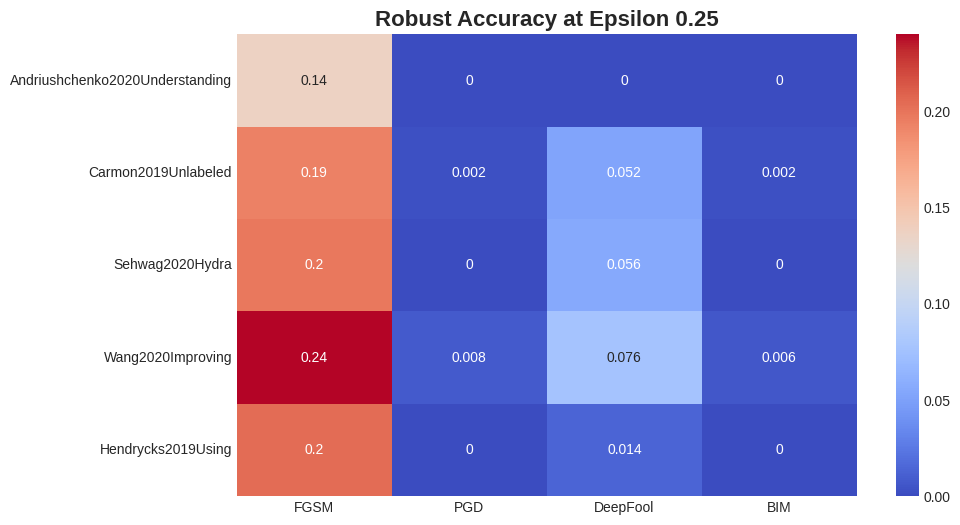

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over each epsilon value and create a heatmap
for eps in epsilon_values:
    # Data preparation for this epsilon
    heatmap_data = [[robust_accuracies[model][eps][attack] for attack in attacks] for model in model_list]

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, xticklabels=attacks, yticklabels=model_list, cmap='coolwarm')
    plt.title(f'Robust Accuracy at Epsilon {eps}', fontsize=16, fontweight='bold')
    plt.show()


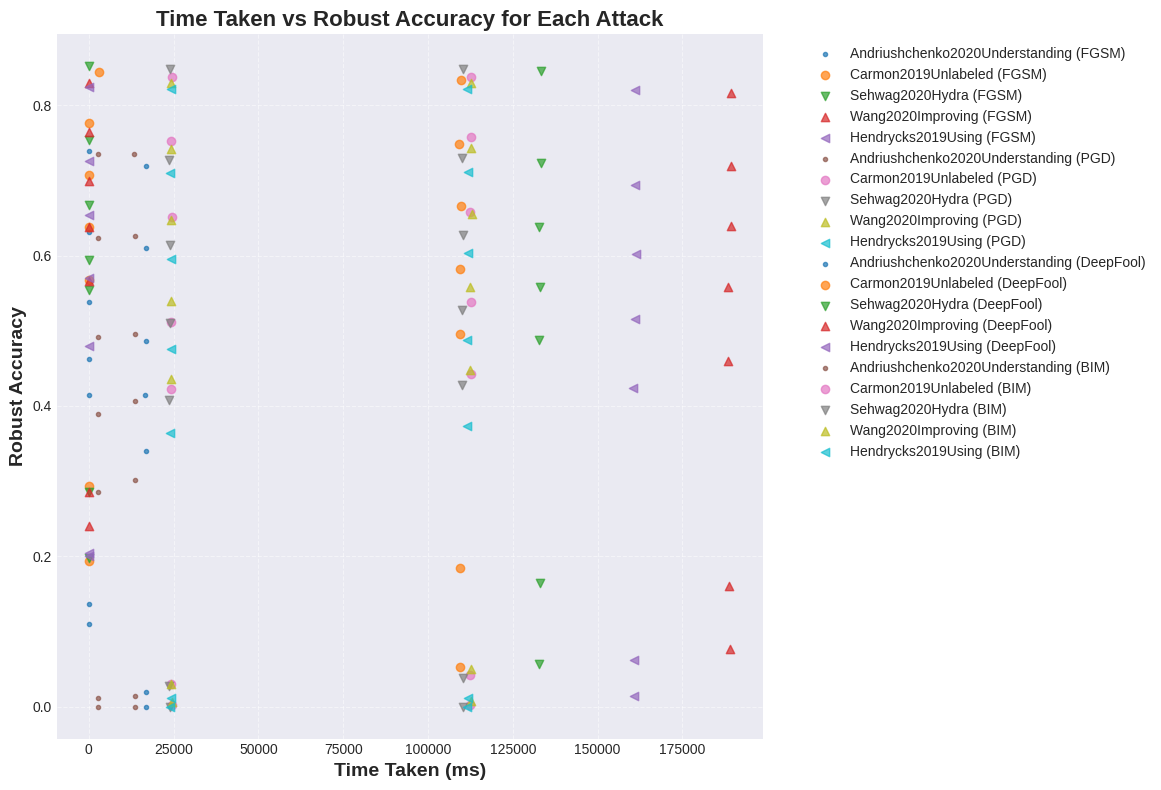

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.markers as markers

# Define marker styles for each model to enhance distinguishability
marker_styles = markers.MarkerStyle.filled_markers[:len(model_list)]

# Data preparation
plt.figure(figsize=(14, 8))

for attack in attacks:
    for i, model in enumerate(model_list):
        time = [times[model][eps][attack] for eps in epsilon_values]
        accuracy = [robust_accuracies[model][eps][attack] for eps in epsilon_values]
        plt.scatter(time, accuracy, label=f"{model} ({attack})", alpha=0.7, marker=marker_styles[i])

plt.xlabel('Time Taken (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Robust Accuracy', fontsize=14, fontweight='bold')
plt.title('Time Taken vs Robust Accuracy for Each Attack', fontsize=16, fontweight='bold')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to accommodate the outside legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


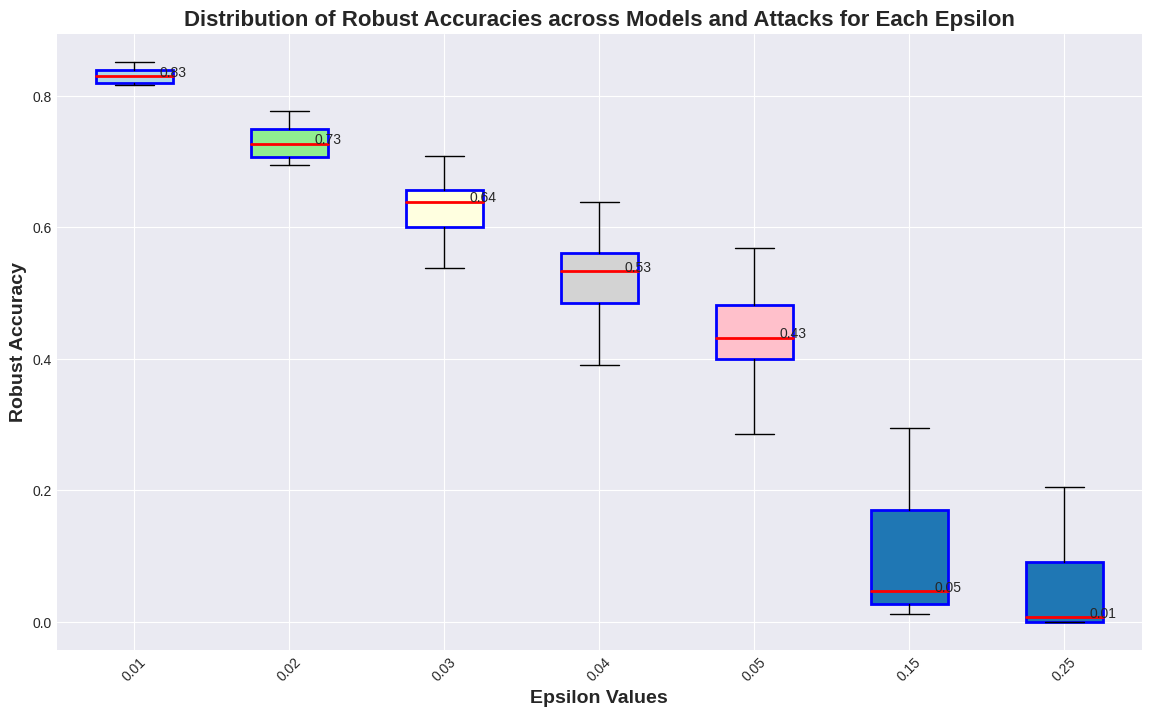

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare labels for each box: combine epsilon values, models, and attacks
labels = []
for eps in epsilon_values:
    for model in models:
        for attack in attacks:
            labels.append(f"{model}\n{attack}\n(eps={eps})")

# Flatten the data to match the new labels
flat_data = [robust_accuracies[model][eps][attack] for eps in epsilon_values for model in models for attack in attacks]

# Group data by epsilon values for boxplot
data_for_boxplot = [flat_data[i:i+len(models)*len(attacks)] for i in range(0, len(flat_data), len(models)*len(attacks))]

# Plotting
plt.figure(figsize=(14, 8))
boxprops = dict(linestyle='-', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=2, color='red')

bplot = plt.boxplot(data_for_boxplot, labels=[str(eps) for eps in epsilon_values], patch_artist=True, boxprops=boxprops, medianprops=medianprops, showfliers=False)

# Color each box
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'pink'][:len(models)*len(attacks)]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Epsilon Values', fontsize=14, fontweight='bold')
plt.ylabel('Robust Accuracy', fontsize=14, fontweight='bold')
plt.title('Distribution of Robust Accuracies across Models and Attacks for Each Epsilon', fontsize=16, fontweight='bold')

# Optional: Annotate median values
for line in bplot['medians']:
    x, y = line.get_xydata()[1]  # top of median line
    plt.text(x, y, f'{y:.2f}', horizontalalignment='center')  # draw above, centered

plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()


https://github.com/RobustBench/robustbench/tree/master

https://github.com/Harry24k/adversarial-attacks-pytorch/blob/master/demo/Performance%20Comparison%20(CIFAR10).ipynb

# **2023 Papers Models**

In [ ]:
model_list = ['Wang2023Better_WRN-70-16', 'Wang2023Better_WRN-28-10', 'Cui2023Decoupled_WRN-34-10', 'Bai2023Improving_edm']
for model_name in model_list:
    # Load your model (update this part based on how your models are actually loaded)
    model = load_model(model_name, norm='Linf')  # This assumes load_model is a function you have defined to load the models

    # Evaluate your model (update based on your actual evaluation function)
    acc = clean_accuracy(model, images, labels)  # This assumes clean_accuracy is a function you have for evaluation
    print('Model: {}'.format(model_name))
    print('- Standard Acc: {}'.format(acc))



In [ ]:
pip install foolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
import datetime
import foolbox as fb
import pickle
import torch

# Other necessary imports...
model_list = ['Wang2023Better_WRN-70-16', 'Wang2023Better_WRN-28-10', 'Cui2023Decoupled_WRN-34-10', 'Bai2023Improving_edm']

epsilon_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.15, 0.25]  # List of epsilon values
all_results = {}  # Dictionary to store all results

epsilon_values = [0.01,0.02,0.03,0.04, 0.05, 0.15, 0.25]  # List of epsilon values
all_results = {}  # Dictionary to store all results

for eps in epsilon_values:
    print(f"Epsilon: {eps}")
    eps_results = {}  # Dictionary to store results for this epsilon

    for model_name in model_list:
        model_results = {}  # Dictionary to store results for this model
        print('Model: {}'.format(model_name))
        model = load_model(model_name, norm='Linf')
        fmodel = fb.PyTorchModel(model, bounds=(0, 1))

        # List of Foolbox attacks
        attacks = [
            ('FGSM', fb.attacks.FGSM(random_start=False)),
            ('PGD', fb.attacks.LinfPGD(random_start=False)),
            ('DeepFool', fb.attacks.LinfDeepFoolAttack()),
            ('BIM', fb.attacks.LinfBasicIterativeAttack())
        ]

        for attack_name, attack in attacks:
            print(f"- {attack_name}")
            start = datetime.datetime.now()
            _, adv_images, _ = attack(fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=eps)
            end = datetime.datetime.now()
            acc = clean_accuracy(model, adv_images, labels)
            model_results[attack_name] = {'Robust Acc': acc, 'Time (ms)': int((end - start).total_seconds() * 1000)}
            print(f'- Robust Acc: {acc} (Time: {model_results[attack_name]["Time (ms)"]} ms)')

            # Save the result to a pickle file
            output_filename = f'/content/drive/MyDrive/ColabNotebooks/{model_name}_{attack_name}_epsilon{eps}.pkl'
            with open(output_filename, 'wb') as output_file:
                pickle.dump(attack_results, output_file)
            print(f"Result saved to {output_filename}")

        # Add model results to epsilon results
        eps_results[model_name] = model_results
        print()

    # Add epsilon results to all results
    all_results[eps] = eps_results

# Print all results
print("\nAll Results:")
for eps, models in all_results.items():
    print(f"Epsilon: {eps}")
    for model_name, results in models.items():
        print(f'Model: {model_name}')
        for attack, attack_results in results.items():
            for result in attack_results:
                print(f'  {attack} - Robust Acc: {result["Robust Acc"]} (Time: {result["Time (ms)"]} ms)')


Epsilon: 0.01
Model: Wang2023Better_WRN-70-16
Download started: path=models/cifar10/Linf/Wang2023Better_WRN-70-16.pt (gdrive_id=1-RF7ZSS-PAh6bfQcuqx4lh9bc9BUGnap)
Download finished: path=models/cifar10/Linf/Wang2023Better_WRN-70-16.pt (gdrive_id=1-RF7ZSS-PAh6bfQcuqx4lh9bc9BUGnap)
- FGSM
- Robust Acc: 1.0 (Time: 291 ms)
Result saved to /content/drive/MyDrive/ColabNotebooks/Wang2023Better_WRN-70-16_FGSM_epsilon0.01.pkl
- PGD
- Robust Acc: 1.0 (Time: 17683 ms)
Result saved to /content/drive/MyDrive/ColabNotebooks/Wang2023Better_WRN-70-16_PGD_epsilon0.01.pkl
- DeepFool
- Robust Acc: 1.0 (Time: 20774 ms)
Result saved to /content/drive/MyDrive/ColabNotebooks/Wang2023Better_WRN-70-16_DeepFool_epsilon0.01.pkl
- BIM
- Robust Acc: 1.0 (Time: 4317 ms)
Result saved to /content/drive/MyDrive/ColabNotebooks/Wang2023Better_WRN-70-16_BIM_epsilon0.01.pkl

Model: Wang2023Better_WRN-28-10
Download started: path=models/cifar10/Linf/Wang2023Better_WRN-28-10.pt (gdrive_id=1-6MYKJdECDVGaWjj6GgqvaT95BGKhUvI)


KeyboardInterrupt: 

In [ ]:
import pickle

results_directory = '/content/drive/MyDrive/ColabNotebooks/'  # Directory containing the results
loaded_results = {}

for file in os.listdir(results_directory):
    if file.endswith('.pkl'):
        filepath = os.path.join(results_directory, file)
        with open(filepath, 'rb') as f:
            loaded_results[file] = pickle.load(f)

# Now, loaded_results contains all your attack results
